In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import zscore, pearsonr
from scipy.spatial.distance import pdist, squareform
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

from tqdm import tqdm

In [4]:
dat = pd.read_pickle('../datasets/NNN/unit_data_full.pkl')

In [27]:
# =========================
# CONFIG
# =========================
ONSET_MS = 0          # stimulus onset (ms)
WINDOW_MS = 350        # analyze 0-300 ms post onset
BIN_MS = 1             # temporal bin size (ms). If not 1, change indices below
K_RANGE = range(2, 11) # candidates for number of clusters
RANDOM_STATE = 0
N_INIT = "auto"        # or an int (e.g., 20) if on older sklearn
MAX_IMAGES_FOR_RSA = None   # to keep RSA runtime reasonable. None for all images
RSA_METRIC = "correlation"       # correlation type when comparing RDM vectors
SAVE_PREFIX = "clustering_out"

In [6]:
def get_unit_timecourse(row, start=None, end=None):
    """
    Return the unit's avg PSTH within the analysis window.
    If avg_psth is missing, derive it by averaging img_psth across images.
    Ensures shape (T,) where T=end-start.
    """
    avg = row['avg_psth']
    if avg is None or (isinstance(avg, float) and np.isnan(avg)):
        A = np.asarray(row['img_psth'])  # (time, images)
        if A.ndim != 2:
            raise ValueError("img_psth must be 2D (time x images)")
        avg = A.mean(axis=1)
    avg = np.asarray(avg)
    if avg.ndim != 1:
        raise ValueError("avg_psth must be 1D (time,)")
    # take all values if start/end is not specified
    if start is None:
        start = 0
        end = len(avg)
    if len(avg) < end:
        raise ValueError(f"avg_psth length {len(avg)} < required end index {end}")
    return avg[start:end]  # (T,)

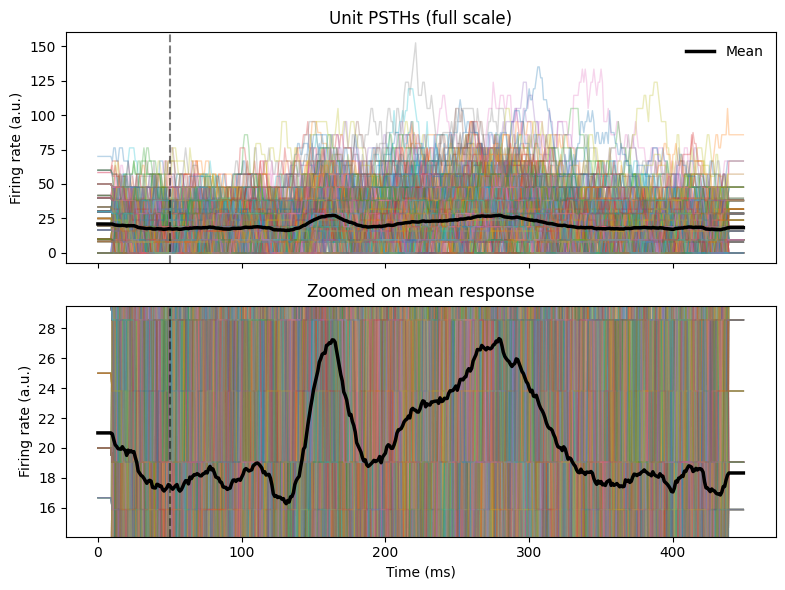

In [93]:
unit_idx = 500           # <-- pick your unit
ONSET_MS = 50
BIN_MS = 1
N_SHOW = 500            # image psth's to show

A = np.asarray(dat.iloc[unit_idx]["img_psth"])  # shape: (time, images)
T, I = A.shape
time_axis = np.arange(T) * BIN_MS

# pick some random images (or your own indices)
rng = np.random.default_rng(0)
img_ids = np.sort(rng.choice(I, size=N_SHOW, replace=False))

fig, axes = plt.subplots(2, 1, figsize=(8, 6), sharex=True)

# ---------- Full view ----------
ax = axes[0]
for img in img_ids:
    sns.lineplot(x=time_axis, y=A[:, img], alpha=0.3, lw=1.0, ax=ax)
ax.plot(time_axis, A[:, img_ids].mean(axis=1), color='k', lw=2.5, label='Mean')
ax.axvline(50, ls="--", color="k", alpha=0.5)
ax.set_title("Unit PSTHs (full scale)")
ax.set_ylabel("Firing rate (a.u.)")
ax.legend(frameon=False)

# ---------- Zoomed view ----------
ax = axes[1]
for img in img_ids:
    sns.lineplot(x=time_axis, y=A[:, img], alpha=0.2, lw=1.0, ax=ax)
mean_trace = A[:, img_ids].mean(axis=1)
ax.plot(time_axis, mean_trace, color='k', lw=2.5)
ax.axvline(50, ls="--", color="k", alpha=0.5)
ax.set_title("Zoomed on mean response")
ax.set_xlabel("Time (ms)")
ax.set_ylabel("Firing rate (a.u.)")

# Zoom in on the y-axis around the mean trace
margin = 0.2 * (mean_trace.max() - mean_trace.min())
ax.set_ylim(mean_trace.min() - margin, mean_trace.max() + margin)

plt.tight_layout()
plt.show()

In [ ]:
A = np.asarray(dat.iloc[unit_idx]["img_psth"])  # (time, images)

fig,axes = plt.subplots(2,1, figsize=(8,6), sharex=True)

ax = axes[0]
# normalize per image (shape-only)
A_norm_time = A / (A.max(axis=0, keepdims=True) + 1e-9)
sns.lineplot(A_norm_time, alpha=0.3, ax=ax)
mean_trace = A_norm_time.mean(axis=1)
ax.plot(np.arange(len(A)), mean_trace, color='k', lw=2.5)
ax.set_title('per-image time course normalization')
ax.legend().remove()

ax = axes[1]
# normalize per unit (all images)
A_norm_unit = A / (A.max() + 1e-9)
sns.lineplot(A_norm_unit, alpha=0.3, ax=ax)
mean_trace = A_norm_unit.mean(axis=1)
ax.plot(np.arange(len(A)), mean_trace, color='k', lw=2.5)
ax.set_title('across-image time course normalization')
ax.legend().remove()

plt.tight_layout()
plt.show()

In [36]:
# start and end times calculated from CONFIG
start = int(ONSET_MS / BIN_MS)
end   = start + int(WINDOW_MS / BIN_MS)

timecourses = []
valid_idx = []  # track which rows succeed
for i, row in dat.iterrows():
    try:
        tc = get_unit_timecourse(row, start, end)
        timecourses.append(tc)
        valid_idx.append(i)
    except Exception as e:
        # skip units that don't have valid PSTH
        print(f"Skipping unit {i}: {e}")
        pass
    
X = np.vstack(timecourses)  # (n_valid_units, T)

# Z-score each unit across time (mean=0, std=1)
X = zscore(X, axis=1)
# Replace any NaNs from zero-variance rows with zeros
X = np.nan_to_num(X, nan=0.0, posinf=0.0, neginf=0.0)

In [21]:
# =========================
# INERTIA/SILHOUETTE: choose K
# =========================
sil_scores = []
labels_by_k = {}
inertias = {}
for k in tqdm(K_RANGE):
    km = KMeans(n_clusters=k, random_state=RANDOM_STATE, n_init=N_INIT)
    lab = km.fit_predict(X)
    # inertia to measure fit of k clusters
    km.fit(X)
    inertias[k] = km.inertia_
    labels_by_k[k] = lab
    # alternatively, use silhouette
    # requires >1 cluster and less than n_samples
    sil = silhouette_score(X, lab)
    sil_scores.append((k, sil))

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [01:01<00:00,  6.85s/it]


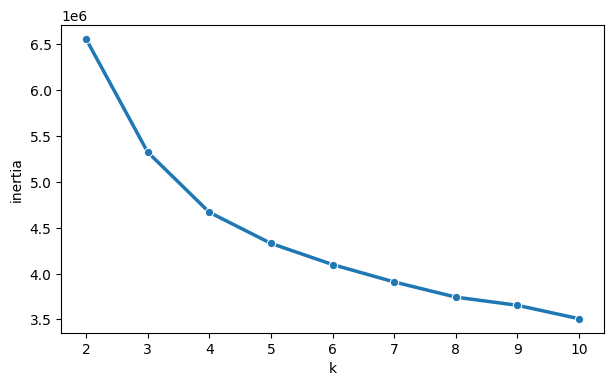

Silhouette scores:
  k=2: silhouette=0.2267
  k=3: silhouette=0.2359
  k=4: silhouette=0.2052
  k=5: silhouette=0.1706
  k=6: silhouette=0.1615
  k=7: silhouette=0.1534
  k=8: silhouette=0.1547
  k=9: silhouette=0.1587
  k=10: silhouette=0.1576
=> Selected k=3 (silhouette=0.2359)


In [24]:
# by INERTIA
df = pd.DataFrame({
    "k": list(inertias.keys()),
    "inertia": list(inertias.values())
})

# seaborn lineplot
plt.figure(figsize=(7, 4))
sns.lineplot(data=df, x="k", y="inertia", marker="o", linewidth=2.5)
plt.show()

# by SILHOUETTE score
# Pick best K
best_k, best_sil = max(sil_scores, key=lambda t: t[1])
labels = labels_by_k[best_k]

print("Silhouette scores:")
for k, s in sil_scores:
    print(f"  k={k}: silhouette={s:.4f}")
print(f"=> Selected k={best_k} (silhouette={best_sil:.4f})")

# Attach labels back to the original `dat`
dat['cluster'] = np.nan
dat.loc[valid_idx, 'cluster'] = labels

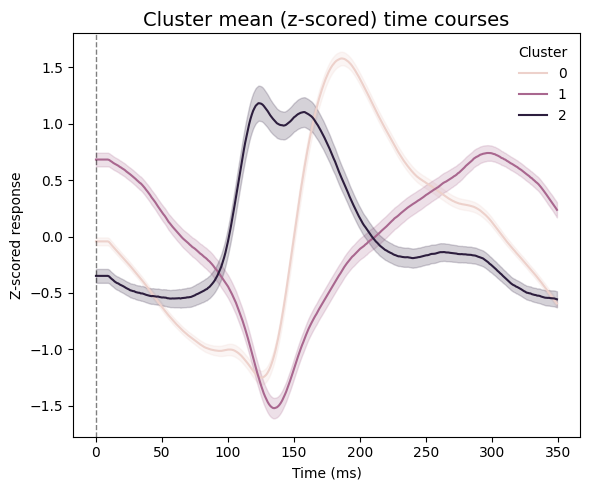

In [83]:
# =========================
# PLOTS: cluster mean time courses
# =========================
T = X.shape[1]
time_axis = np.arange(start, end)  # time in ms

df_plot = pd.DataFrame({
    "time": np.tile(time_axis, X.shape[0]),
    "response": X.flatten(),
    "cluster": np.repeat(labels, T)
})

# --- Seaborn plot ---
plt.figure(figsize=(6, 5))
sns.lineplot(
    data=df_plot,
    x="time",
    y="response",
    hue="cluster",
    errorbar=("se", 10), # for viz
)

# onset line
plt.axvline(ONSET_MS, ls="--", lw=1, color="k", alpha=0.5)

plt.title("Cluster mean (z-scored) time courses", fontsize=14)
plt.xlabel("Time (ms)")
plt.ylabel("Z-scored response")
plt.legend(title="Cluster", frameon=False)
plt.tight_layout()
plt.show()

In [28]:
# =========================
# RSA per cluster (time × time similarity)
# =========================
# For RSA, we use img_psth (time x images) for units in each cluster.
# At each time bin within the window, build population-by-image matrix for that cluster:
#   M_t = (n_units_in_cluster x n_images_sub)
# Compute image×image correlation matrix at that time => similarity
# Convert to RDM vector = 1 - corr (upper triangle).
# Compare RDM vectors across all time pairs via correlation => time×time RSA.

def rdm_vector_from_matrix(M, metric='correlation'):
    """
    Args:
        M: (ndarray)
        metric: (str)
    Given a matrix M with shape (n_units, n_images), compute the image×image
    RDM and return the vectorized upper triangle (excluding diagonal).
    """
    M = np.asarray(M, dtype=float)
    # center columns (images) across units, matching the corrcoef approach
    M -= M.mean(axis=0, keepdims=True)
    M = np.nan_to_num(M, nan=0.0, posinf=0.0, neginf=0.0)
    # pdist expects observations in rows, so pass images as rows -> M.T
    rdm_vec = pdist(M.T, metric=metric)  # already 1 - corr
    return rdm_vec

def rsa_time_by_time_for_cluster(cluster_id):
    idx_units = np.where(dat.loc[valid_idx, 'cluster'].values == cluster_id)[0]
    if len(idx_units) < 2:
        print(f"[RSA] Cluster {cluster_id}: not enough units ({len(idx_units)})")
        return None

    # Stack img_psth for units in this cluster
    # We may subsample images for speed/memory
    # First, figure out number of images from the first unit
    sample_unit = dat.iloc[valid_idx[idx_units[0]]]['img_psth']
    A0 = np.asarray(sample_unit)
    if A0.ndim != 2:
        raise ValueError("img_psth must be 2D (time x images)")
    # should be (450, 1072) for full sample
    n_time, n_images = A0.shape 

    # Subsample images if needed
    if MAX_IMAGES_FOR_RSA is not None and n_images > MAX_IMAGES_FOR_RSA:
        rng = np.random.default_rng(RANDOM_STATE)
        img_sel = np.sort(rng.choice(n_images, size=MAX_IMAGES_FOR_RSA, replace=False))
    else:
        img_sel = np.arange(n_images)

    # Prepare an array: for each time t in [start:end), we will build an RDM vector
    rdm_vecs = []
    for t in range(start, end):
        # Build matrix (units x images_sel) at this time
        rows = []
        for u_rel in idx_units:
            unit_idx = valid_idx[u_rel]
            A = np.asarray(dat.iloc[unit_idx]['img_psth'])  # (time, images)
            rows.append(A[t, img_sel])
        M = np.vstack(rows)  # (n_units_in_cluster, n_images_sub)
        # Normalize across units for stability (optional)
        # M = zscore(M, axis=0)  # z-score per image across units
        M = np.nan_to_num(M, nan=0.0, posinf=0.0, neginf=0.0)
        # upper triangular of image x image RDMS
        triu = rdm_vector_from_matrix(M)
        rdm_vecs.append(triu)

    rdm_vecs = np.vstack(rdm_vecs)  # (T, n_pairs)
    # time x time similarity by correlating RDM vectors across time
    Tloc = rdm_vecs.shape[0]
    rsa_mat = np.empty((Tloc, Tloc), dtype=float)
    for i in range(Tloc):
        vi = rdm_vecs[i]
        # vector normalize
        vi0 = (vi - vi.mean())
        den_i = np.sqrt((vi0**2).sum()) + 1e-12
        for j in range(i, Tloc):
            vj = rdm_vecs[j]
            vj0 = (vj - vj.mean())
            den_j = np.sqrt((vj0**2).sum()) + 1e-12
            r = float((vi0 @ vj0) / (den_i * den_j))
            rsa_mat[i, j] = rsa_mat[j, i] = r

    return rsa_mat, img_sel

In [35]:
cluster_id = 0

idx_units = np.where(dat.loc[valid_idx, 'cluster'].values == cluster_id)[0]
if len(idx_units) < 2:
    print(f"[RSA] Cluster {cluster_id}: not enough units ({len(idx_units)})")

# Stack img_psth for units in this cluster
# We may subsample images for speed/memory
# First, figure out number of images from the first unit
sample_unit = dat.iloc[valid_idx[idx_units[0]]]['img_psth']
A0 = np.asarray(sample_unit)
if A0.ndim != 2:
    raise ValueError("img_psth must be 2D (time x images)")
n_time, n_images = A0.shape
print(A0.shape)

# Subsample images if needed
if MAX_IMAGES_FOR_RSA is not None and n_images > MAX_IMAGES_FOR_RSA:
    rng = np.random.default_rng(RANDOM_STATE)
    img_sel = np.sort(rng.choice(n_images, size=MAX_IMAGES_FOR_RSA, replace=False))
else:
    img_sel = np.arange(n_images)
print(img_sel.shape)

# Prepare an array: for each time t in [start:end), we will build an RDM vector
rdm_vecs = []
for t in tqdm(range(50, 55)):
    # Build matrix (units x images_sel) at this time
    rows = []
    for u_rel in idx_units:
        unit_idx = valid_idx[u_rel]
        A = np.asarray(dat.iloc[unit_idx]['img_psth'])  # (time, images)
        rows.append(A[t, img_sel])
    M = np.vstack(rows)  # (n_units_in_cluster, n_images_sub)
    # Normalize across units for stability (optional)
    # M = zscore(M, axis=0)  # z-score per image across units
    M = np.nan_to_num(M, nan=0.0, posinf=0.0, neginf=0.0)
    
    # upper triangular of image x image RDMS
    triu = rdm_vector_from_matrix(M)
    rdm_vecs.append(triu)

rdm_vecs = np.vstack(rdm_vecs)  # (T, n_pairs)
print(rdm_vecs.shape)
# # time x time similarity by correlating RDM vectors across time
# Tloc = rdm_vecs.shape[0]
# rsa_mat = np.empty((Tloc, Tloc), dtype=float)

(450, 1072)
(1072,)


  8%|████████████▉                                                                                                                                                     | 28/350 [03:21<38:40,  7.21s/it]


KeyboardInterrupt: 

In [76]:
# how the paper does it??
cluster_id = 2

idx_usnits = np.where(dat.loc[valid_idx, 'cluster'].values == cluster_id)[0]

# Select only the rows you want, based on cluster id
subset = dat.iloc[idx_units]["img_psth"]

# Convert to list of arrays
arrays = [np.asarray(x) for x in subset]
# shape: (units, time_points, images)
img_psth_array = np.stack(arrays, axis=0)
subset = img_psth_array[:, start:end, :]

for unit in range(subset.shape[0]):
    unit_img_psth = subset[unit]
    # img x img rdm vector
    rdm_vec = pdist(unit_img_psth.T, metric=metric)
    break
# # average across images to get each unit's average psth
# avg_psth = np.mean(img_psth_array, axis=2)
# # normalize each timecourse
# avg_psth_norm = zscore(avg_psth, axis=1)
# # subset to specific time range
# avg_psth_norm = avg_psth_norm[:, :350]

# # rdm
# metric = 'correlation'
# rdm_vec = pdist(avg_psth_norm.T, metric=metric)
# rdm = squareform(rdm_vec)
# sns.heatmap(rdm)
# plt.title(f'Cluster {cluster_id}')

(350, 1072)


In [ ]:
uidx = 0
numviz = 10

for i in range(numviz):
    

In [86]:
Z = zscore(subset, axis=1)
C = np.einsum('uti,utj->uij', Z, Z) / (T - 1) 
C.shape

KeyboardInterrupt: 

Text(0.5, 1.0, 'Cluster 2')

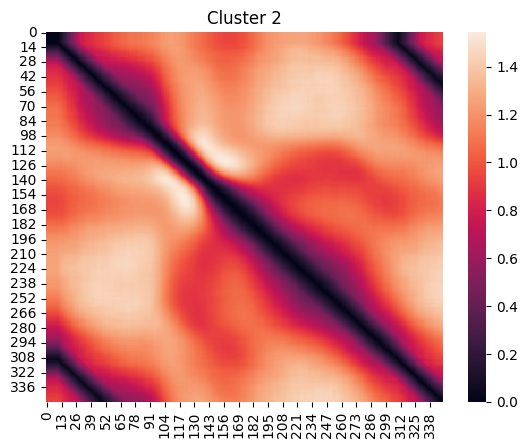

In [72]:
'''
RDM of average time traces, by cluster
'''
cluster_id = 2

idx_usnits = np.where(dat.loc[valid_idx, 'cluster'].values == cluster_id)[0]

# Select only the rows you want, based on cluster id
subset = dat.iloc[idx_units]["img_psth"]

# Convert to list of arrays
arrays = [np.asarray(x) for x in subset]
# shape: (units, time_points, images)
img_psth_array = np.stack(arrays, axis=0)

# average across images to get each unit's average psth
avg_psth = np.mean(img_psth_array, axis=2)
# normalize each timecourse
avg_psth_norm = zscore(avg_psth, axis=1)
# subset to specific time range
avg_psth_norm = avg_psth_norm[:, :350]

# rdm
metric = 'correlation'
rdm_vec = pdist(avg_psth_norm.T, metric=metric)
rdm = squareform(rdm_vec)
sns.heatmap(rdm)
plt.title(f'Cluster {cluster_id}')

<Axes: >

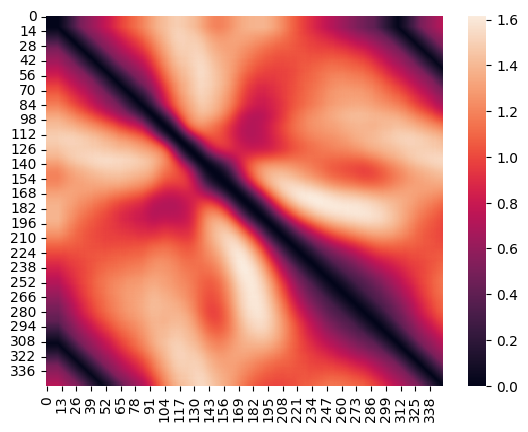

  0%|                                                                                                                                                                             | 0/3 [00:00<?, ?it/s]

[RSA] Computing time×time similarity for cluster 0 ...


 33%|██████████████████████████████████████████████████████▋                                                                                                             | 1/3 [02:01<04:03, 121.97s/it]

[RSA] Computing time×time similarity for cluster 1 ...


 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                       | 2/3 [03:13<01:32, 92.36s/it]

[RSA] Computing time×time similarity for cluster 2 ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [04:37<00:00, 92.62s/it]


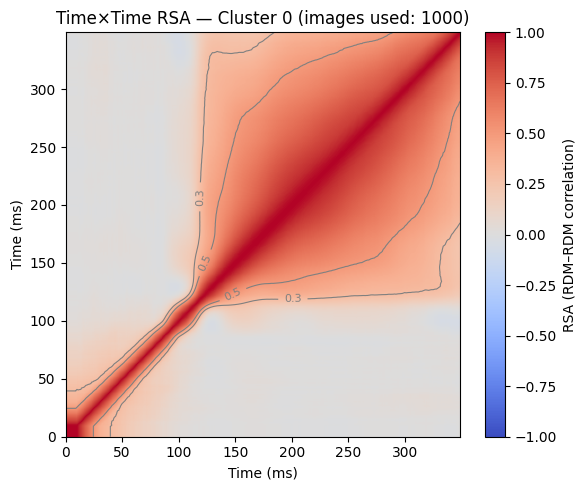

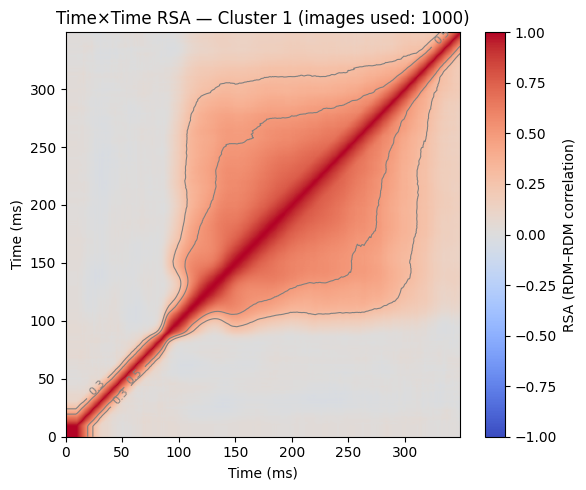

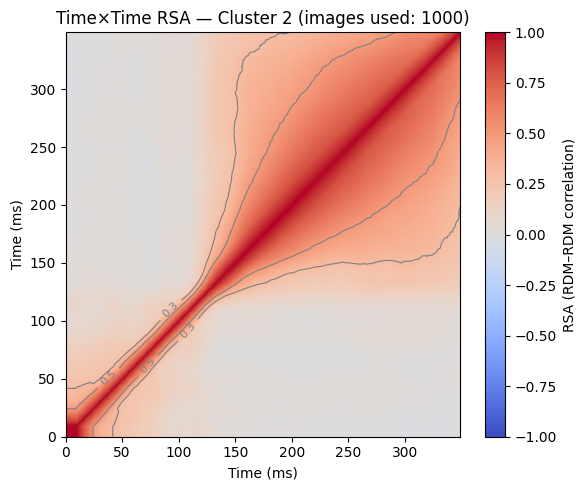

In [51]:
rsa_results = {}
for c in tqdm(range(best_k)):
    print(f"[RSA] Computing time×time similarity for cluster {c} ...")
    out = rsa_time_by_time_for_cluster(c)
    if out is None:
        continue
    rsa_mat, img_sel = out
    rsa_results[c] = rsa_mat

    plt.figure(figsize=(6, 5))
    plt.imshow(rsa_mat, origin='lower', aspect='auto', vmin=-1, vmax=1,
               extent=[start, end-1, start, end-1],
              cmap='coolwarm')
    plt.colorbar(label="RSA (RDM–RDM correlation)")

    # ➕ add contour lines at correlation levels 0.3 and 0.5
    levels = [0.3, 0.5]
    contours = plt.contour(
        np.linspace(start, end-1, rsa_mat.shape[0]),  # x-axis
        np.linspace(start, end-1, rsa_mat.shape[1]),  # y-axis
        rsa_mat,
        levels=levels,
        colors='gray',
        linewidths=0.8,
    )
    plt.clabel(contours, fmt="%.1f", colors='gray', fontsize=8)

    plt.title(f"Time×Time RSA — Cluster {c} (images used: {len(img_sel)})")
    plt.xlabel("Time (ms)")
    plt.ylabel("Time (ms)")
    plt.tight_layout()

In [83]:
# =========================
# CONFIG (edit as needed)
# =========================
TYPE2_CLUSTER = 1          # set to the cluster label that corresponds to "Type 2"
MONKEY_ID = 3
ONSET_MS = 0              # stimulus onset (ms)
WINDOW_MS = 350            # analyze 0–300 ms post-onset
BIN_MS = 1                 # ms/bin (change if your PSTH bin differs)
THRESH_NORM_AVG = 0.3      # drop images below this normalized average response
N_SHOW = 5 

In [84]:
def is_anterior_face_roi(roi):
    if roi is None:
        return False
    tok0 = str(roi).split("_", 1)[0]  # first chunk only
    return "a" in tok0.lower()

mask = (
    (dat["monkey"] == MONKEY_ID) &
    (dat["cluster"] == TYPE2_CLUSTER) &
    (dat["roi"].apply(is_anterior_face_roi))
)

subset = dat.loc[mask].copy()

In [85]:
# =========================
# BUILD POPULATION PSTH PER IMAGE
# Per-unit scalar normalization = divide each unit by its max within [onset : onset+300ms] across ALL images.
# Then average normalized traces across units to get population PSTH per image.
# =========================
start = int(ONSET_MS / BIN_MS)
end   = start + int(WINDOW_MS / BIN_MS)

# infer sizes from first valid unit
sample = np.asarray(subset.iloc[0]["img_psth"])   # (time, images), e.g., (450, 1072)
T_full, N_img = sample.shape

pop_psth = np.zeros((end - start, N_img), dtype=float)
n_units = 0

for _, row in subset.iterrows():
    A = np.asarray(row["img_psth"])
    if A.ndim != 2 or A.shape[0] < end:
        continue
    W = A[start:end, :]          # (Twin, N_img)
    u_max = W.max()              # scalar per unit
    if not np.isfinite(u_max) or u_max <= 0:
        continue
    pop_psth += (W / u_max)
    n_units += 1

if n_units == 0:
    raise RuntimeError("No units passed windowing/normalization.")
pop_psth /= n_units  # average across units

In [87]:
max(norm_avg)

np.float64(0.06334204695541958)

In [86]:
# =========================
# IMAGE-WISE METRICS
# =========================
norm_avg   = pop_psth.mean(axis=0)       # mean over time
peak_amp   = pop_psth.max(axis=0)        # max over time (y-axis)
peak_idx   = pop_psth.argmax(axis=0)     # index of max
peak_lat_ms= peak_idx * BIN_MS           # ms since onset (x-axis)

# Apply exclusion: normalized average < 0.7
THRESH_NORM_AVG = 0
keep = norm_avg >= THRESH_NORM_AVG
kept_count = int(keep.sum())
if kept_count == 0:
    raise RuntimeError("No images passed THRESH_NORM_AVG; consider lowering it.")

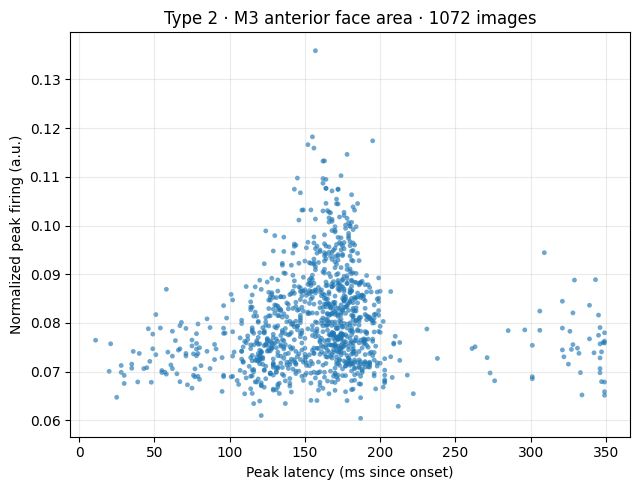

In [88]:
# =========================
# SCATTER: Peak latency (x) vs normalized peak firing (y)
# =========================
plt.figure(figsize=(6.5, 5))
plt.scatter(peak_lat_ms[keep], peak_amp[keep], s=12, alpha=0.65, edgecolor="none")
plt.xlabel("Peak latency (ms since onset)")
plt.ylabel("Normalized peak firing (a.u.)")
plt.title(f"Type 2 · M3 anterior face area · {kept_count} images")
plt.grid(alpha=0.25)
plt.tight_layout()

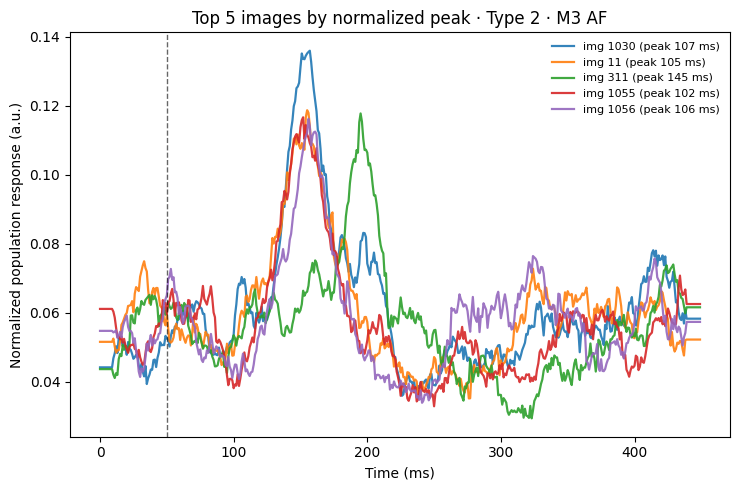

In [82]:
# =========================
# FULL TIME TRACES for top-N images (by normalized peak)
# Use the SAME per-unit scalar normalization (from 0–300 ms window across all images),
# but now plot the FULL 0..T_full trajectory.
# =========================
top_idx_within_kept = np.argsort(peak_amp[keep])[-N_SHOW:]          # positions within kept subset
kept_image_ids = np.where(keep)[0]                                   # original image indices
top_image_ids = kept_image_ids[top_idx_within_kept][::-1]            # top N, descending

time_axis_full = np.arange(T_full) * BIN_MS
pop_traces_full = []  # averaged across units per image

for img in top_image_ids:
    acc = np.zeros(T_full, dtype=float)
    cnt = 0
    for _, row in subset.iterrows():
        A = np.asarray(row["img_psth"])  # (T_full, N_img)
        if A.ndim != 2 or img >= A.shape[1] or A.shape[0] < end:
            continue
        # reuse same scalar normalization
        u_max = A[start:end, :].max()
        if not np.isfinite(u_max) or u_max <= 0:
            continue
        acc += (A[:, img] / u_max)
        cnt += 1
    if cnt > 0:
        pop_traces_full.append(acc / cnt)
    else:
        pop_traces_full.append(None)

plt.figure(figsize=(7.5, 5))
for img, tr in zip(top_image_ids, pop_traces_full):
    if tr is None:
        continue
    lbl = f"img {int(img)} (peak {int(peak_lat_ms[img])} ms)"
    plt.plot(time_axis_full, tr, lw=1.6, alpha=0.9, label=lbl)
plt.axvline(ONSET_MS, ls="--", lw=1, color="k", alpha=0.6)
plt.xlabel("Time (ms)")
plt.ylabel("Normalized population response (a.u.)")
plt.title(f"Top {N_SHOW} images by normalized peak · Type 2 · M3 AF")
plt.legend(fontsize=8, frameon=False)
plt.tight_layout()